# Zillow Regression Project
### By Carl Griffin
### June 15, 2021

In [1]:
import numpy as np
import pandas as pd
import math
from acquire import get_zillow_data
from wrangle_zillow import prep_zillow_data, wrangle_zillow, train_validate_test, Min_Max_Scaler, outlier_calculation
from evaluate import baseline_mean_errors, baseline_median_errors, plot_residuals, regression_errors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

## Project Planning
### Initial Questions
- What constitutes a single unit property?
- What features are the best drivers for predicting a single unit property's value?
### Initial Hypotheses

- $H_0$: The features number of bedrooms, number of bathrooms, and square feet offer no predictive value for a single unit property's value.
- $H_a$: These features help predict a single unit property's value.



### Acquire and examine the data

Acquire the data from the zillow database ('Single Family Residential' properties from  May-Aug, 2017)



In [2]:
df = get_zillow_data()

In [3]:
df

,propertylandusetypeid,transactiondate,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,fips
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48,6037.0
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90,6037.0
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69,6037.0
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72,6059.0
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27,6037.0
...,...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68,6059.0
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88,6059.0
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03,6037.0
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66,6037.0


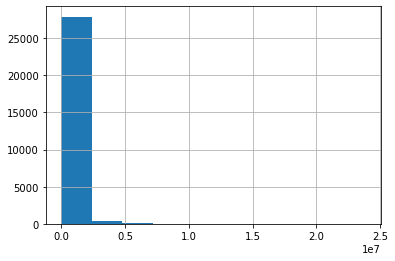

In [5]:
df.taxvaluedollarcnt.hist()
plt.show()

In [6]:
df.isnull().sum()

propertylandusetypeid            0
transactiondate                  0
calculatedfinishedsquarefeet    73
bedroomcnt                       0
bathroomcnt                      0
taxvaluedollarcnt                1
taxamount                        1
fips                             0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28419 non-null  float64
 1   transactiondate               28419 non-null  object 
 2   calculatedfinishedsquarefeet  28346 non-null  float64
 3   bedroomcnt                    28419 non-null  float64
 4   bathroomcnt                   28419 non-null  float64
 5   taxvaluedollarcnt             28418 non-null  float64
 6   taxamount                     28418 non-null  float64
 7   fips                          28419 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.7+ MB


### Prep the data

In [8]:
df = prep_zillow_data(df)

In [9]:
# Remove nulls from calculatedsquarefeet
df.loc[df['calculatedfinishedsquarefeet'].isin(['NaN'])].head()
indexsize = df.loc[df['calculatedfinishedsquarefeet'].isin(['NaN'])].index
df.drop(indexsize, inplace=True)

In [10]:
# Remove nulls from taxvaluedollarcnt
df.loc[df['taxvaluedollarcnt'].isin(['NaN'])].head()
indexsize = df.loc[df['taxvaluedollarcnt'].isin(['NaN'])].index
df.drop(indexsize, inplace=True)

In [11]:
# Remove nulls from taxamount
df.loc[df['taxamount'].isin(['NaN'])].head()
indexsize = df.loc[df['taxamount'].isin(['NaN'])].index
df.drop(indexsize, inplace=True)

In [12]:
df.shape

(28344, 8)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28344 entries, 0 to 28418
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28344 non-null  float64
 1   transactiondate               28344 non-null  object 
 2   calculatedfinishedsquarefeet  28344 non-null  float64
 3   bedroomcnt                    28344 non-null  float64
 4   bathroomcnt                   28344 non-null  float64
 5   taxvaluedollarcnt             28344 non-null  float64
 6   taxamount                     28344 non-null  float64
 7   fips                          28344 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.2+ MB


In [14]:
# Rename the columns into something more readable
df = df.rename(columns={'propertylandusetypeid': 'land_use_typeid', 'bathroomcnt': 'num_bathrooms', 'bedroomcnt': 'num_bedrooms',
                       'calculatedfinishedsquarefeet': 'square_feet', 'taxvaluedollarcnt': 'appraised_value', 'taxamount': 'taxes'})

### Explore the Data

In [45]:
df.square_feet.describe()

count    28344.000000
mean      1931.810965
std       1013.662251
min        240.000000
25%       1276.000000
50%       1669.000000
75%       2319.000000
max      35640.000000
Name: square_feet, dtype: float64

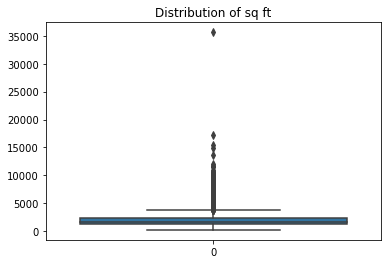

In [46]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

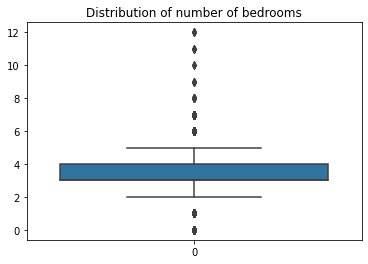

In [47]:
sns.boxplot(data=df.num_bedrooms)
plt.title('Distribution of number of bedrooms')
plt.show()

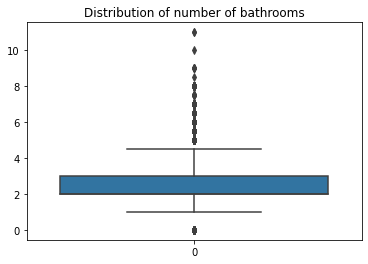

In [48]:
sns.boxplot(data=df.num_bathrooms)
plt.title('Distribution of number of bathrooms')
plt.show()

In [49]:
df = outlier_calculation(df, 'num_bedrooms')

For num_bedrooms the lower bound is 1.5 and  upper bound is 5.5


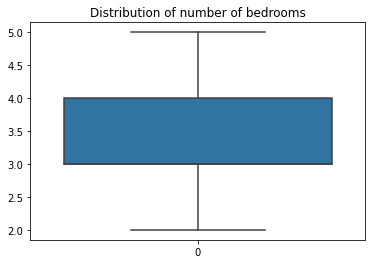

In [50]:
sns.boxplot(data=df.num_bedrooms)
plt.title('Distribution of number of bedrooms')
plt.show()

In [51]:
df = outlier_calculation(df, 'num_bathrooms')

For num_bathrooms the lower bound is 0.5 and  upper bound is 4.5


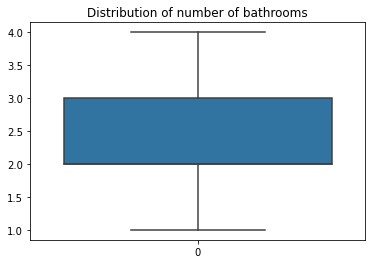

In [52]:
sns.boxplot(data=df.num_bathrooms)
plt.title('Distribution of number of bathrooms')
plt.show()

In [53]:
df = outlier_calculation(df, 'square_feet')

For square_feet the lower bound is -115.5 and  upper bound is 3576.5


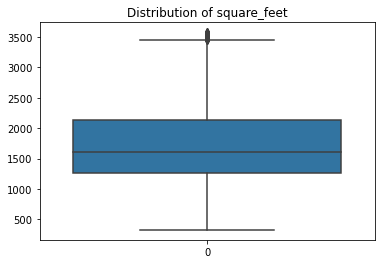

In [54]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of square_feet')
plt.show()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25880 entries, 0 to 28418
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   land_use_typeid  25880 non-null  float64
 1   transactiondate  25880 non-null  object 
 2   square_feet      25880 non-null  float64
 3   num_bedrooms     25880 non-null  float64
 4   num_bathrooms    25880 non-null  float64
 5   appraised_value  25880 non-null  float64
 6   taxes            25880 non-null  float64
 7   fips             25880 non-null  float64
 8   tax_rate         25880 non-null  float64
 9   county_name      25880 non-null  object 
dtypes: float64(8), object(2)
memory usage: 3.4+ MB


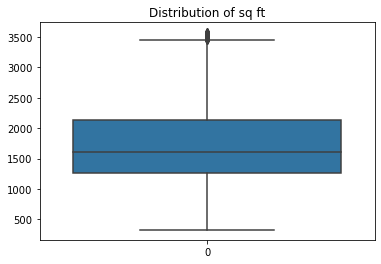

In [56]:
# Plot with outliers removed
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

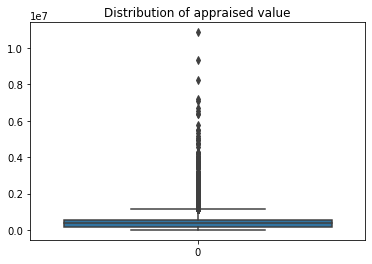

In [57]:
sns.boxplot(data=df.appraised_value)
plt.title('Distribution of appraised value')
plt.show()

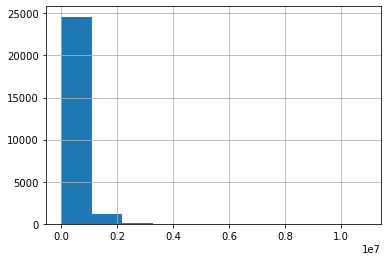

In [58]:
df.appraised_value.hist()
plt.show()

In [59]:
df.transactiondate.value_counts(dropna=False, ascending=True)

2017-07-09      1
2017-06-11      1
2017-07-08      1
2017-05-07      1
2017-08-12      1
             ... 
2017-05-26    469
2017-08-31    483
2017-07-28    514
2017-05-31    527
2017-06-30    740
Name: transactiondate, Length: 118, dtype: int64

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25880 entries, 0 to 28418
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   land_use_typeid  25880 non-null  float64
 1   transactiondate  25880 non-null  object 
 2   square_feet      25880 non-null  float64
 3   num_bedrooms     25880 non-null  float64
 4   num_bathrooms    25880 non-null  float64
 5   appraised_value  25880 non-null  float64
 6   taxes            25880 non-null  float64
 7   fips             25880 non-null  float64
 8   tax_rate         25880 non-null  float64
 9   county_name      25880 non-null  object 
dtypes: float64(8), object(2)
memory usage: 3.4+ MB


In [61]:
# Drop the columns not needed for modeling
df1 = df.drop(columns=['transactiondate', 'land_use_typeid', 'taxes', 'fips', 'county_name'])

In [62]:
df1


,square_feet,num_bedrooms,num_bathrooms,appraised_value,tax_rate
0,1316.0,3.0,2.0,205123.0,1.28
1,1458.0,3.0,2.0,136104.0,1.70
2,1421.0,2.0,1.0,35606.0,1.53
3,2541.0,4.0,3.0,880456.0,1.12
4,1491.0,3.0,2.0,107110.0,1.31
...,...,...,...,...,...
28414,1187.0,4.0,1.5,465999.0,1.19
28415,3015.0,5.0,3.0,852813.0,1.37
28416,2992.0,5.0,3.0,1120000.0,1.22
28417,1574.0,3.0,3.0,563463.0,1.23


#### Split the data

In [63]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df1, 'appraised_value')

In [64]:
y_train

22794    772507.0
15997    416091.0
20568     49454.0
6296     207362.0
25689    469585.0
           ...   
20211    253750.0
12750    100841.0
24975     84881.0
3409     100580.0
10077    783227.0
Name: appraised_value, Length: 14492, dtype: float64

In [65]:
train.shape, validate.shape, test.shape

((14492, 5), (6212, 5), (5176, 5))

In [66]:
train.head()

,square_feet,num_bedrooms,num_bathrooms,appraised_value,tax_rate
22794,2384.0,3.0,3.0,772507.0,1.17
15997,1480.0,3.0,2.0,416091.0,1.23
20568,1247.0,3.0,1.0,49454.0,1.95
6296,2169.0,4.0,3.5,207362.0,1.23
25689,2044.0,3.0,2.5,469585.0,1.56


#### Scale the data

In [67]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [68]:
X_train_scaled

,square_feet,num_bedrooms,num_bathrooms,tax_rate
22794,0.633231,0.333333,0.666667,0.013484
15997,0.355077,0.333333,0.333333,0.014219
20568,0.283385,0.333333,0.000000,0.023045
6296,0.567077,0.666667,0.833333,0.014219
25689,0.528615,0.333333,0.500000,0.018264
...,...,...,...,...
20211,0.676615,0.333333,0.333333,0.007232
12750,0.533846,0.666667,0.666667,0.015813
24975,0.313231,0.333333,0.333333,0.026477
3409,0.560615,0.666667,0.333333,0.015690


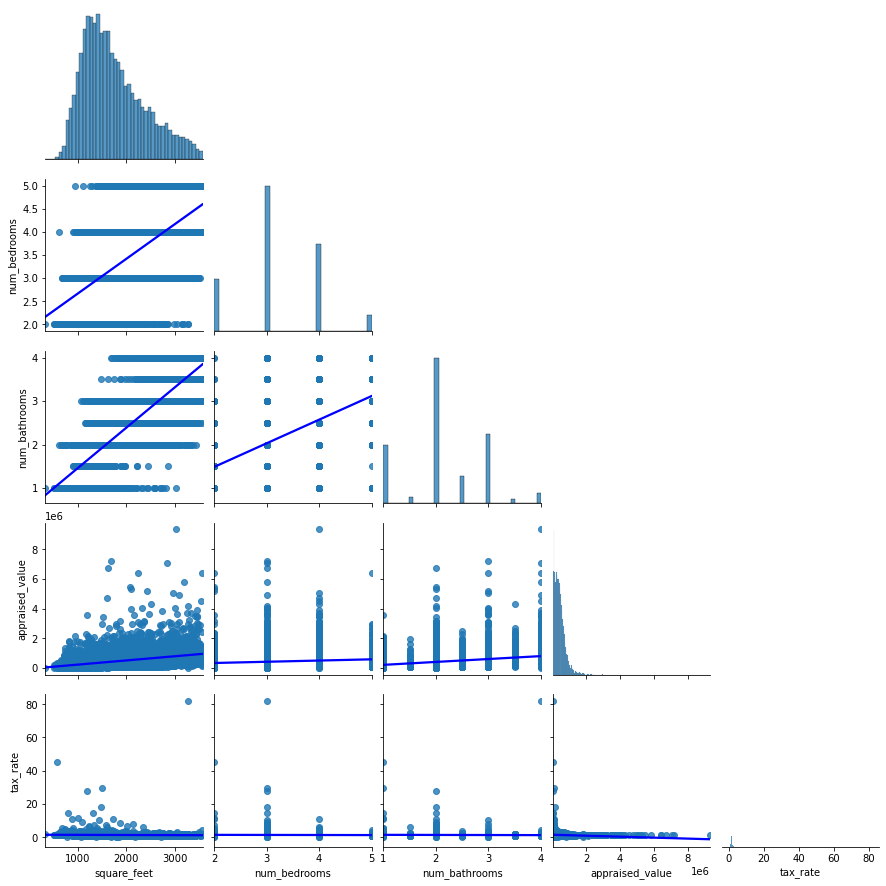

In [69]:
# Plot the pairs
sns.pairplot(train, kind = 'reg', corner=True, plot_kws = {'line_kws': {'color': 'blue'}})

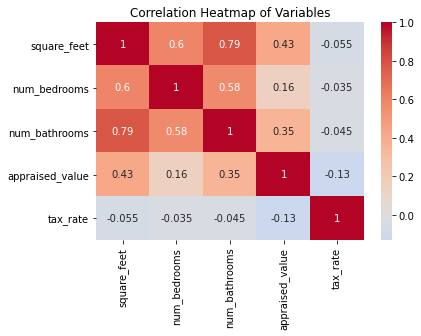

In [70]:
# Create a heatmap to show correlations
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True)

plt.title('Correlation Heatmap of Variables')
plt.show()

#### Takeaways

According to the graphs above, the number of bathrooms are the most closely correlated to the appraised value followed by square feet.

#### Statistical Modeling

Hypothesis (using pearsonr):
    
- $H_O$:  There is no correlation between number of bathrooms and appraised value.

- $H_a$:  There is a correlation between number of bathrooms and appraised value.

In [71]:
corr, p = stats.pearsonr(train.num_bathrooms, train.appraised_value)
# set alpha
alpha = 0.05
print(corr, p)

if p < alpha:
    print(f'\nWe can reject the null hypothesis.')
else:
    print(f'\nWe fail to reject the null hypothesis.')

0.35204911444516673 0.0

We can reject the null hypothesis.


Independent T-test:

Hypothesis (using T_test):
    
- $H_O$:  There is no correlation between number of bathrooms and appraised value.

- $H_a$:  There is a correlation between number of bathrooms and appraised value.

In [72]:
t, p = stats.ttest_ind(train.appraised_value, train.square_feet, equal_var=False)

In [73]:
t, p

(127.09112625593218, 0.0)

Using the same alpha as before, we can reject the null hypothesis as p < alpha.

### Modeling and Evaluation

Establish a baseline

In [74]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# 1. Predict taxvaluedollarcnt_pred_mean
AV_pred_mean = y_train['appraised_value'].mean()
y_train['AV_pred_mean'] = AV_pred_mean
y_validate['AV_pred_mean'] = AV_pred_mean
y_test['AV_pred_mean'] = AV_pred_mean

# 2. compute taxvaluedollarcnt_pred_median
AV_pred_median = y_train['appraised_value'].median()
y_train['AV_pred_median'] = AV_pred_median
y_validate['AV_pred_median'] = AV_pred_median
y_test['AV_pred_median'] = AV_pred_median

In [75]:
y_train.head()

,appraised_value,AV_pred_mean,AV_pred_median
22794,772507.0,442223.200386,359249.5
15997,416091.0,442223.200386,359249.5
20568,49454.0,442223.200386,359249.5
6296,207362.0,442223.200386,359249.5
25689,469585.0,442223.200386,359249.5


In [76]:
#Evaluate the baseline model using the mean
baseline_mean_errors(y_train.appraised_value)

{'sse': 2522538881119854.0,
 'mse': 174064234137.44507,
 'rmse': 417210.05996673316}

In [77]:
#Evaluate the baseline model using the median
baseline_median_errors(y_train.appraised_value)

{'sse': 2622311010899531.0,
 'mse': 180948869093.2605,
 'rmse': 425380.8518178275}

In [78]:
y_validate.head()

,appraised_value,AV_pred_mean,AV_pred_median
23338,423838.0,442223.200386,359249.5
20410,318000.0,442223.200386,359249.5
21610,53587.0,442223.200386,359249.5
11368,329106.0,442223.200386,359249.5
27414,457703.0,442223.200386,359249.5


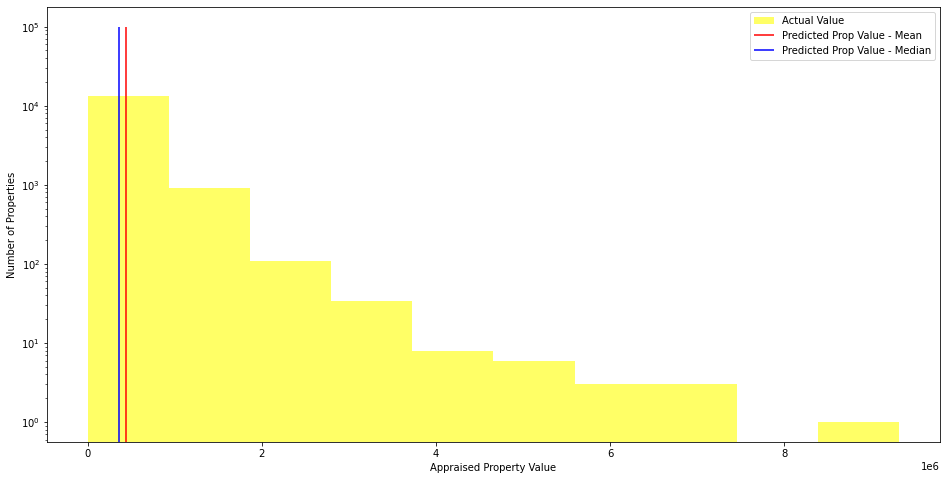

In [79]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16, 8))
plt.hist(y_train.appraised_value, color='yellow', alpha=.6, label="Actual Value", log=True)
plt.vlines(y_train.appraised_value.mean(), 0, 10**5, color='red', label="Predicted Prop Value - Mean")
plt.vlines(y_train.appraised_value.median(), 0, 10**5, color='blue', label="Predicted Prop Value - Median")
plt.xlabel("Appraised Property Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

#### Takeaways

- The predicted mean value performed better than the median.

In [80]:
y_train.head()

,appraised_value,AV_pred_mean,AV_pred_median
22794,772507.0,442223.200386,359249.5
15997,416091.0,442223.200386,359249.5
20568,49454.0,442223.200386,359249.5
6296,207362.0,442223.200386,359249.5
25689,469585.0,442223.200386,359249.5


In [81]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'AV_pred_median'}, inplace=True)
y_validate.drop(columns={'AV_pred_median'}, inplace=True)
y_test.drop(columns={'AV_pred_median'}, inplace=True)
y_train.head()

,appraised_value,AV_pred_mean
22794,772507.0,442223.200386
15997,416091.0,442223.200386
20568,49454.0,442223.200386
6296,207362.0,442223.200386
25689,469585.0,442223.200386


In [82]:
y_train.rename(columns={'AV_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'AV_pred_mean': 'yhat_baseline'}, inplace=True)
y_test.rename(columns={'AV_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

,appraised_value,yhat_baseline
22794,772507.0,442223.200386
15997,416091.0,442223.200386
20568,49454.0,442223.200386
6296,207362.0,442223.200386
25689,469585.0,442223.200386


Linear Regression (lm)

In [83]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.appraised_value)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled)

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['appraised_value']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['appraised_value']


In [84]:
y_train.head()

,appraised_value,yhat_baseline,yhat_lm,residual,baseline_residual
22794,772507.0,442223.200386,702459.006426,-70047.993574,-330283.799614
15997,416091.0,442223.200386,380154.556388,-35936.443612,26132.200386
20568,49454.0,442223.200386,227619.276546,178165.276546,392769.200386
6296,207362.0,442223.200386,568807.248774,361445.248774,234861.200386
25689,469585.0,442223.200386,557700.948098,88115.948098,-27361.799614


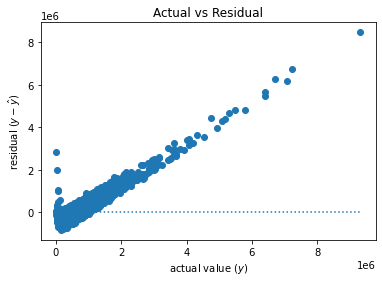

sse     1.984827e+15
ess     5.377118e+14
tss     2.522539e+15
mse     1.369602e+11
rmse    3.700813e+05
r^2     2.131629e-01
dtype: float64

In [85]:
#Use evaluate model to visualize the residuals
plot_residuals(y_train.appraised_value, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
regression_errors(y_train.appraised_value, y_train.yhat_lm)

LassoLars (lars)

In [86]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.appraised_value)

# predict train
y_train['yhat_lars'] = lars.predict(X_train_scaled)


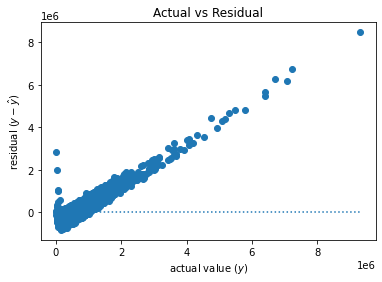

sse     1.984828e+15
ess     5.365153e+14
tss     2.522539e+15
mse     1.369603e+11
rmse    3.700815e+05
r^2     2.126886e-01
dtype: float64

In [87]:
#Use evaluate model to visualize the residuals
plot_residuals(y_train.appraised_value, y_train.yhat_lars)

#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
regression_errors(y_train.appraised_value, y_train.yhat_lars)

TweedieRegressor (glm)

In [88]:
# create the model object
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.appraised_value)

# predict train
y_train['yhat_glm'] = glm.predict(X_train_scaled)


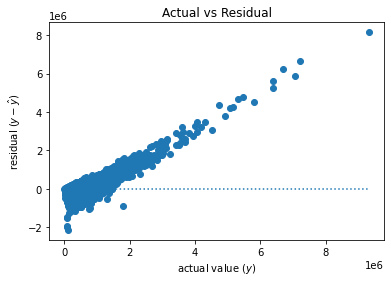

sse     1.783941e+15
ess     7.566013e+14
tss     2.522539e+15
mse     1.230983e+11
rmse    3.508537e+05
r^2     2.999364e-01
dtype: float64

In [89]:
#Use evaluate model to visualize the residuals
plot_residuals(y_train.appraised_value, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
regression_errors(y_train.appraised_value, y_train.yhat_glm)

#### Takeaway

- The best modeling turns out to be the Lasso/Lars model, but they were all close.
- Lasso/Lars had the best r^2.

In [90]:
# predict validate
y_test['yhat_lars'] = lars.predict(X_test_scaled)

# compute residuals
y_test['residual'] = y_test['yhat_lars'] - y_test['appraised_value']
y_test['baseline_residual'] = y_test['yhat_baseline'] - y_test['appraised_value']

#How does the Lasso/Lars model perform on out of sample data?
regression_errors(y_test.appraised_value, y_test.yhat_lars)

sse     6.565008e+14
ess     1.845908e+14
tss     8.333577e+14
mse     1.268355e+11
rmse    3.561398e+05
r^2     2.215024e-01
dtype: float64

In [91]:
y_test.head()

,appraised_value,yhat_baseline,yhat_lars,residual,baseline_residual
26225,275074.0,442223.200386,284076.289869,9002.289869,167149.200386
25045,522000.0,442223.200386,505609.224651,-16390.775349,-79776.799614
4403,121087.0,442223.200386,563946.014068,442859.014068,321136.200386
8087,803062.0,442223.200386,483616.414542,-319445.585458,-360838.799614
19671,290816.0,442223.200386,394356.338189,103540.338189,151407.200386


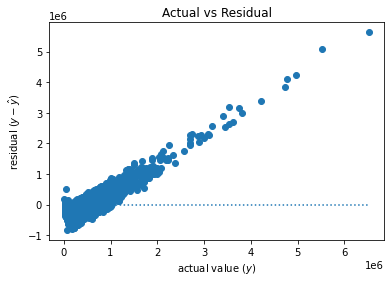

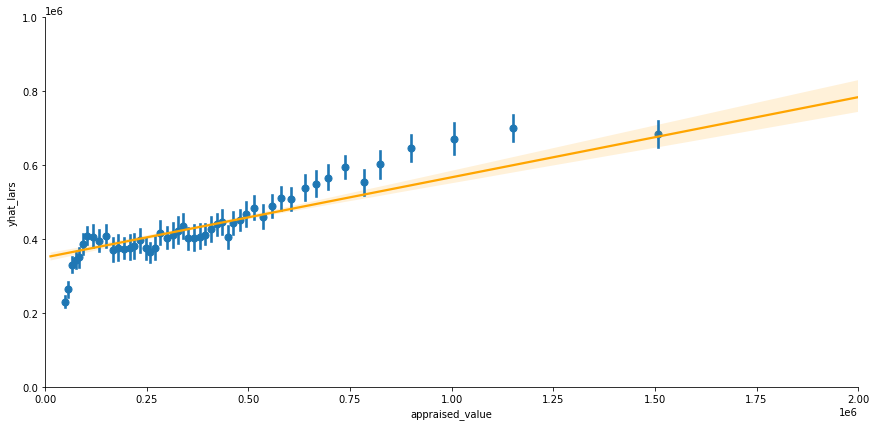

In [92]:
#Use evaluate model to visualize the residuals
plot_residuals(y_test.appraised_value, y_test.yhat_lars)
a_plot = sns.lmplot(x = 'appraised_value', y = 'yhat_lars', data = y_test, height = 6, aspect = 2, x_bins=50,  fit_reg=True, line_kws={"color":"orange"})
a_plot.set(xlim=(0, 2000000), ylim=(0,1000000))
plt.show()

### Additional required data

- How do tax rate differ between the 3 counties?
- (FIPS: 6037 - Los Angeles County, California
-  6059 - Orange County, California
-  6111 - Ventura County, California)

In [17]:
# Add the county name into the dataframe
df['county_name'] = df['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})


In [18]:
df

,land_use_typeid,transactiondate,square_feet,num_bedrooms,num_bathrooms,appraised_value,taxes,fips,tax_rate,county_name
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48,6037.0,0.012809,Los Angeles
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90,6037.0,0.017045,Los Angeles
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69,6037.0,0.015270,Los Angeles
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72,6059.0,0.011153,Orange
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27,6037.0,0.013064,Los Angeles
...,...,...,...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68,6059.0,0.011916,Orange
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88,6059.0,0.013676,Orange
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03,6037.0,0.012199,Los Angeles
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66,6037.0,0.012252,Los Angeles


In [19]:
# show counts by county
df.county_name.value_counts()

Los Angeles    17933
Orange          7743
Ventura         2668
Name: county_name, dtype: int64

In [31]:
df.head()

,land_use_typeid,transactiondate,square_feet,num_bedrooms,num_bathrooms,appraised_value,taxes,fips,tax_rate,county_name
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48,6037.0,1.28,Los Angeles
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90,6037.0,1.70,Los Angeles
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69,6037.0,1.53,Los Angeles
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72,6059.0,1.12,Orange
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27,6037.0,1.31,Los Angeles


In [39]:
df['tax_rate'] = round(((df['taxes'] / df['appraised_value'])* 100),2)
print(df.groupby('county_name').tax_rate.mean())

county_name
Los Angeles    1.409127
Orange         1.207425
Ventura        1.176570
Name: tax_rate, dtype: float64


(0.75, 2.0)

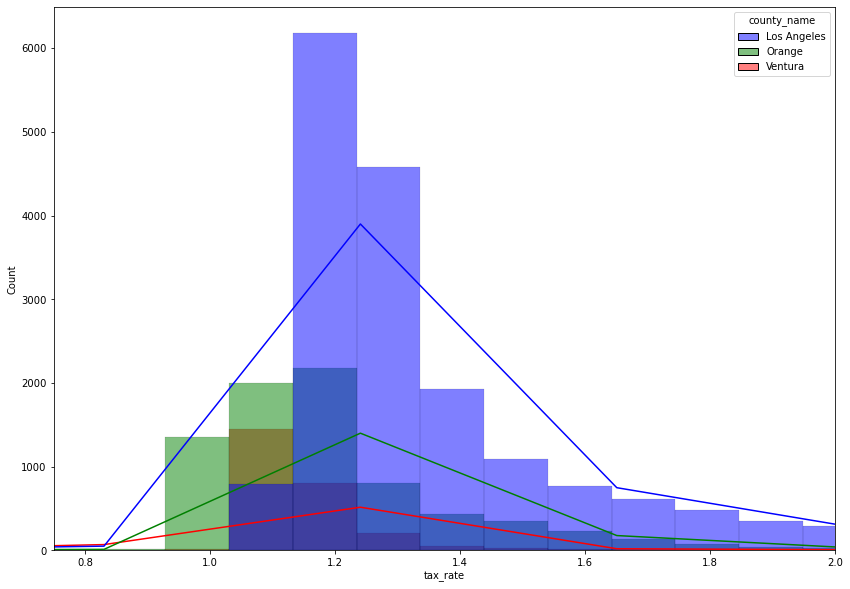

In [43]:
plt.figure(figsize=(14,10))
sns.histplot(data=df, x="tax_rate", hue="county_name",kde = True, bins = 800,  palette={'Los Angeles':'b', 'Orange':'g', 'Ventura':'r'})

plt.xlim(.75, 2)

#### Takeaway

The above graph clearly depicts Los Angeles county has the highest average tax rate, followed by Orange county, then Ventura county.